In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import feather
import warnings
from IPython.display import display
from folium.plugins import HeatMap
#import ipyleaflet
#from ipyleaflet import MarkerCluster, basemaps, CircleMarker
import folium
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

In [2]:
hv = pd.read_csv("hv_cleaned.csv", index_col = [0]) # index_col = [0] removes unnmaed index column
path = 'hv_cleaned.feather'
feather.write_dataframe(hv, path)
hv = feather.read_dataframe(path)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
hv.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Store Category
0,INV-24107200133,12/23/2019,2508,Hy-Vee Food Store #1 / Cedar Rapids,"1843 Johnson Avenue, N.W.",Cedar Rapids,52405,POINT (-91.697941 41.97447),57,LINN,1041100,American Dry Gins,370,PERNOD RICARD USA,32236,Seagrams Extra Dry Gin,12,750.0,6.49,9.74,12,116.88,9.00,2.37,Food Store
1,INV-24090200052,12/20/2019,2649,Hy-Vee #3 / Dubuque,400 Locust St,Dubuque,52001,POINT (-90.666497 42.49721900000001),31,DUBUQUE,1011400,Tennessee Whiskies,85,Brown Forman Corp.,26826,Jack Daniels Old #7 Black Label,12,750.0,15.57,23.36,12,280.32,9.00,2.37,Supermarket
2,INV-24117700068,12/23/2019,2567,Hy-Vee Drugstore / Davenport,2200 West Kimberly,Davenport,52806,POINT (-90.608201 41.560663),82,SCOTT,1011200,Straight Bourbon Whiskies,65,Jim Beam Brands,19066,Jim Beam,12,750.0,10.50,15.75,6,94.50,4.50,1.18,Drugstore
3,INV-24105000057,12/23/2019,2538,Hy-Vee Food Store #3 / Waterloo,1422 Flammang Dr,Waterloo,50702,POINT (-92.327917 42.459938),7,BLACK HAWK,1011100,Blended Whiskies,65,Jim Beam Brands,24456,Kessler Blend Whiskey,12,750.0,5.51,8.27,3,24.81,2.25,0.59,Food Store
4,INV-24117300020,12/23/2019,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1011100,Blended Whiskies,65,Jim Beam Brands,27680,Jim Beam Kentucky Fire Mini,12,50.0,5.40,8.10,12,97.20,0.60,0.15,Drugstore


In [5]:
hv["Date"] =  pd.to_datetime(hv["Date"], format="%m/%d/%Y")

In [6]:
hv['Year'] = hv['Date'].dt.year
hv['Month'] = hv['Date'].dt.month

In [8]:
hv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570810 entries, 0 to 1570809
Data columns (total 27 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Invoice/Item Number    1570810 non-null  object        
 1   Date                   1570810 non-null  datetime64[ns]
 2   Store Number           1570810 non-null  int64         
 3   Store Name             1570810 non-null  object        
 4   Address                1570810 non-null  object        
 5   City                   1570810 non-null  object        
 6   Zip Code               1570810 non-null  int64         
 7   Store Location         1570810 non-null  object        
 8   County Number          1570810 non-null  int64         
 9   County                 1570810 non-null  object        
 10  Category               1570810 non-null  int64         
 11  Category Name          1570810 non-null  object        
 12  Vendor Number          15708

### Adding liquor type column

In [9]:
hv["Type"] = "Liqueur"
hv.loc[hv["Category Name"].str.contains('Gin'), "Type"] = 'Gin'
hv.loc[hv["Category Name"].str.contains('Whiskey'), "Type"] = 'Whiskey'
hv.loc[hv["Category Name"].str.contains('Whiskies'), "Type"] = 'Whiskey'
hv.loc[hv["Category Name"].str.contains('Rum'), "Type"] = 'Rum'
hv.loc[hv["Category Name"].str.contains('Vodka'), "Type"] = 'Vodka'
hv.loc[hv["Category Name"].str.contains('Tequila'), "Type"] = 'Tequila'
hv.loc[hv["Category Name"].str.contains('Mezcal'), "Type"] = 'Mezcal'
hv.loc[hv["Category Name"].str.contains('BRANDIES'), "Type"] = 'Brandy'
hv.loc[hv["Category Name"].str.contains('Brandies'), "Type"] = 'Brandy'
hv.loc[hv["Category Name"].str.contains('Scotch'), "Type"] = 'Scotch'
hv.loc[hv["Category Name"].str.contains('Cocktails'), "Type"] = 'Cocktail'
hv.loc[hv["Category Name"].str.contains('Schnapps'), "Type"] = 'Schnapps'
hv.loc[hv["Category Name"].str.contains('Liqueur'), "Type"] = 'Liqueur'
hv.loc[hv["Category Name"].str.contains('Specialty Packages'), "Type"] = 'Specialty Packages'
hv.loc[hv["Category Name"].str.contains('ANISETTE'), "Type"] = 'Anisette'
hv.loc[hv["Category Name"].str.contains('Brandy'), "Type"] = 'Brandy'
hv.loc[hv["Category Name"].str.contains('Bourbon'), "Type"] = 'Whiskey'

In [10]:
hv.loc[hv["Category Name"].str.contains('Spirits')].head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Store Category,Year,Month,Type
55,INV-24092600180,2019-12-20,2573,Hy-Vee Food Store / Muscatine,2400 2nd Ave,Muscatine,52761,POINT (-91.035138 41.451349),70,MUSCATINE,1091200,Neutral Grain Spirits,384,PIEDMONT DISTILLERS INC,76032,Midnight Moon Original,6,750.0,11.50,17.25,1,17.25,0.75,0.19,Food Store,2019,12,Liqueur
510,INV-24111200112,2019-12-23,2561,Hy-Vee Food Store / Fleur / DSM,4605 Fleur Drive,Des Moines,50321,POINT (-93.64494300000001 41.542748),77,POLK,1091200,Neutral Grain Spirits,154,DUNKEL CORPORATION,77284,Rocket Fuel,12,750.0,6.65,9.98,12,119.76,9.00,2.37,Food Store,2019,12,Liqueur
635,INV-24066600044,2019-12-20,2553,Hy-Vee Food Store / Creston,600 Sheldon,Creston,50801,POINT (-94.372552 41.051462),88,UNION,1091200,Neutral Grain Spirits,154,DUNKEL CORPORATION,77284,Rocket Fuel,12,750.0,6.65,9.98,4,39.92,3.00,0.79,Food Store,2019,12,Liqueur
735,INV-24096300153,2019-12-23,2593,Hy-Vee Food Store / Carroll,905 US Highway 30 West,Carroll,51401,POINT (-94.853591 42.064155),14,CARROLL,1091200,Neutral Grain Spirits,434,LUXCO INC,41846,Everclear Alcohol,12,750.0,8.00,12.00,12,144.00,9.00,2.37,Food Store,2019,12,Liqueur
746,INV-24085100010,2019-12-20,2616,Hy-Vee Food and Drug / Clinton,901 South 4th St,Clinton,52732,POINT (-90.193204 41.836268000000004),23,CLINTON,1091200,Neutral Grain Spirits,384,PIEDMONT DISTILLERS INC,76032,Midnight Moon Original,6,750.0,11.50,17.25,6,103.50,4.50,1.18,Food & Drugstore,2019,12,Liqueur


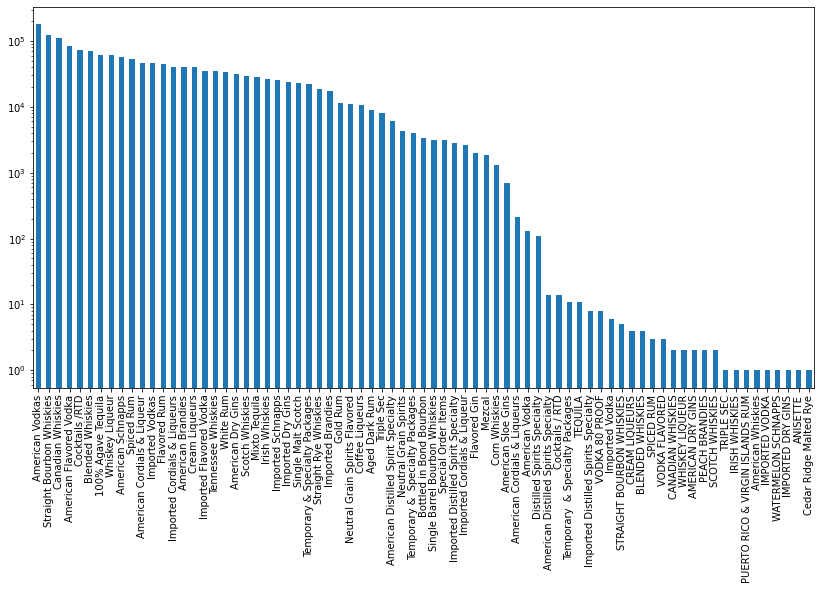

In [11]:
plt.figure(figsize = (14,7))
hv['Category Name'].value_counts().plot.bar()
plt.yscale("log")

- American Vodkas are the most popular transaction in Hy-Vee stores (Iowa)

### Vendor

<Figure size 1440x720 with 0 Axes>

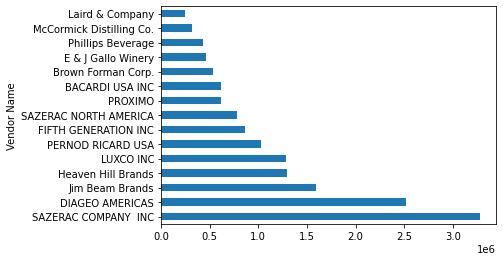

<Figure size 1440x720 with 0 Axes>

In [12]:
hv.groupby("Vendor Name")["Bottles Sold"].sum().sort_values(ascending = False).head(15).plot(kind ="barh")
plt.figure(figsize = (20,10))

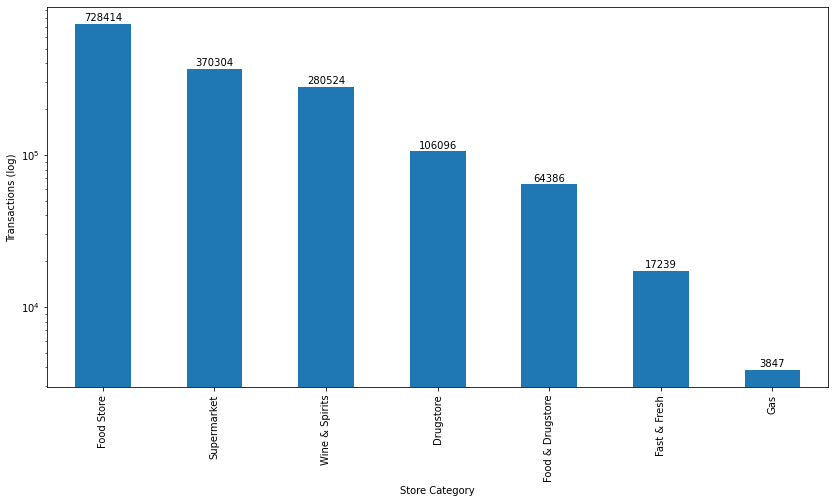

In [13]:
plt.figure(figsize = (14,7))
ax = hv['Store Category'].value_counts().plot.bar()
plt.yscale("log")
plt.xlabel('Store Category')
plt.ylabel('Transactions (log)')


for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

<AxesSubplot:xlabel='Store Category', ylabel='Bottles Sold'>

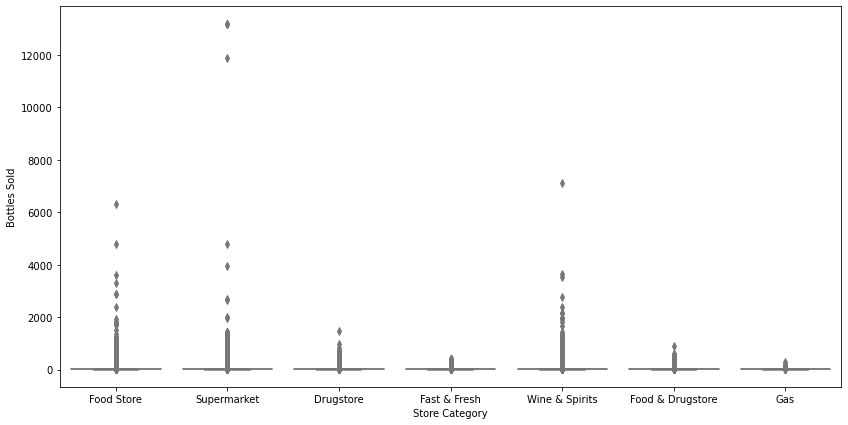

In [14]:
plt.figure(figsize = (14,7))
sns.boxplot(x="Store Category", y="Bottles Sold", data=hv, linewidth=1.5, color='lightsteelblue')

- Most people in Iowa who are customers of the Hy-Vee chain, purchase their liquor most often at food stores and least at Gas stations

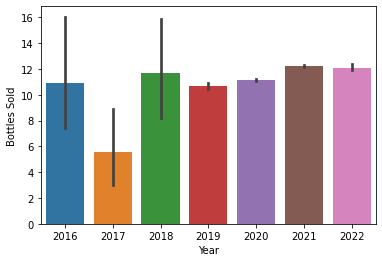

In [15]:
ax = sns.barplot(x = "Year", y = "Bottles Sold", data = hv)
plt.show()

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()


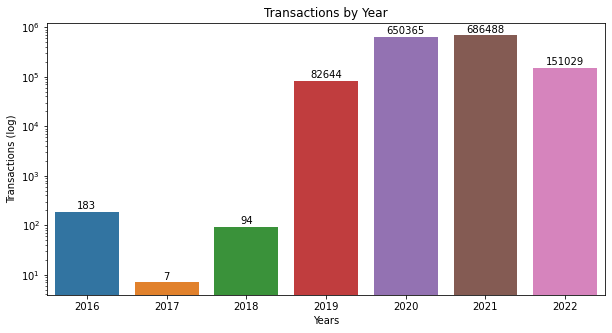

In [16]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(hv['Year'])
plt.yscale("log")
plt.xlabel('Years')
plt.ylabel('Transactions (log)')
plt.title('Transactions by Year')

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

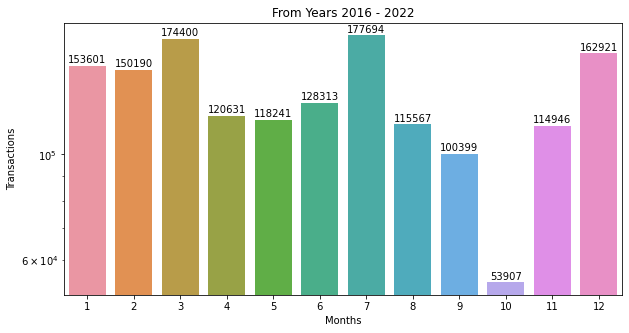

In [17]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(hv['Month'])
plt.yscale("log")
plt.xlabel('Months')
plt.ylabel('Transactions')
plt.title("From Years 2016 - 2022")

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

In [18]:
hv["Store Category"].unique()

array(['Food Store', 'Supermarket', 'Drugstore', 'Fast & Fresh',
       'Wine & Spirits', 'Food & Drugstore', 'Gas'], dtype=object)

In [19]:
supermarket = hv[hv["Store Category"] == "Supermarket"]
foodstore = hv[hv["Store Category"] == "Food Store"]
gas = hv[hv["Store Category"] == "Gas"]
drugstore = hv[hv["Store Category"] == "Drugstore"]
fast_fresh = hv[hv["Store Category"] == "Fast & Fresh"]
wine_spirit = hv[hv["Store Category"] == "Wine & Spirits"]
food_drug = hv[hv["Store Category"] == "Food & Drugstore"]

In [20]:
category_name_top10 = hv['Category Name'].value_counts().head(10)

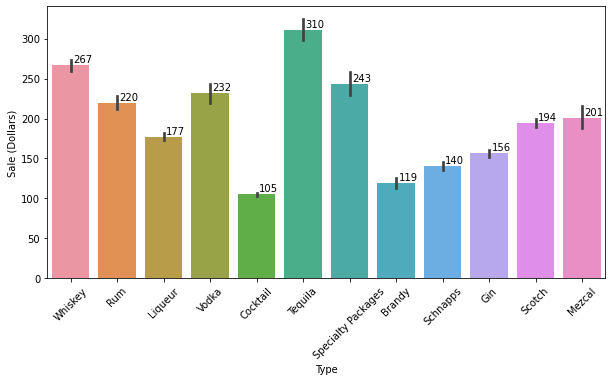

In [21]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Type", y = "Sale (Dollars)", data = supermarket)
plt.xticks(rotation=45)

    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(12, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

In [22]:
hv.loc[hv["Category Name"].str.contains('Special')].head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Store Category,Year,Month,Type
32,INV-24117300032,2019-12-23,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1701100,Temporary & Specialty Packages,420,MOET HENNESSY USA,100873,Ardbeg 10YR w/Ardbone Tin,6,750.0,26.49,39.74,6,238.44,4.50,1.18,Drugstore,2019,12,Specialty Packages
45,INV-24116900112,2019-12-23,2670,Hy-Vee Food Store / Coralville,2004 8th St,Coralville,52241,POINT (-91.591868 41.682337000000004),52,JOHNSON,1092100,Imported Distilled Spirit Specialty,353,"John Ernest Distillery, Inc.",65750,Maestro Agavero Gold,12,1000.0,7.00,10.50,48,504.00,48.00,12.68,Food Store,2019,12,Liqueur
114,INV-24099700020,2019-12-23,2665,Hy-Vee / Waukee,1005 E Hickman Rd,Waukee,50263,POINT (-93.854477 41.615059),25,DALLAS,1701100,Temporary & Specialty Packages,259,Heaven Hill Brands,2229,Christian Bros Holiday Nog,12,750.0,4.47,6.71,12,80.52,9.00,2.37,Supermarket,2019,12,Specialty Packages
151,INV-24113000061,2019-12-23,2509,Hy-Vee / Drugtown #1 / Cedar Rapids,1520 6th St SW,Cedar Rapids,52404,POINT (-91.67706 41.962419),57,LINN,1701100,Temporary & Specialty Packages,205,E & J Gallo Winery,39492,New Amsterdam Pink Whitney,12,750.0,7.50,11.25,3,33.75,2.25,0.59,Supermarket,2019,12,Specialty Packages
172,INV-24110700220,2019-12-23,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1092100,Imported Distilled Spirit Specialty,421,SAZERAC COMPANY INC,77487,Tortilla Gold DSS,12,1000.0,4.85,7.28,660,4804.80,660.00,174.35,Supermarket,2019,12,Liqueur


### supermarket sales by liquor type

In [23]:
sm_sales_by_type = pd.DataFrame(supermarket.groupby(["Type"])["Sale (Dollars)"].sum()).reset_index()
sm_sales_by_type

,Type,Sale (Dollars)
0,Brandy,1462054.13
1,Cocktail,1888923.64
2,Gin,2296807.46
3,Liqueur,9933409.62
4,Mezcal,121571.71
5,Rum,7904324.34
6,Schnapps,2655139.83
7,Scotch,2386083.45
8,Specialty Packages,1718117.12
9,Tequila,6957524.82


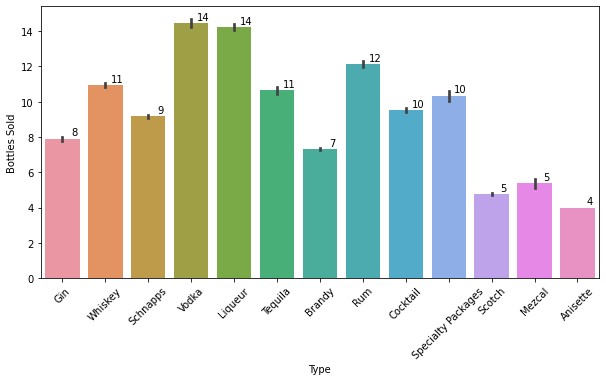

In [24]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Type", y = "Bottles Sold", data = hv)
plt.xticks(rotation=45)

    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(12, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

### Foodstore sales by liquor type

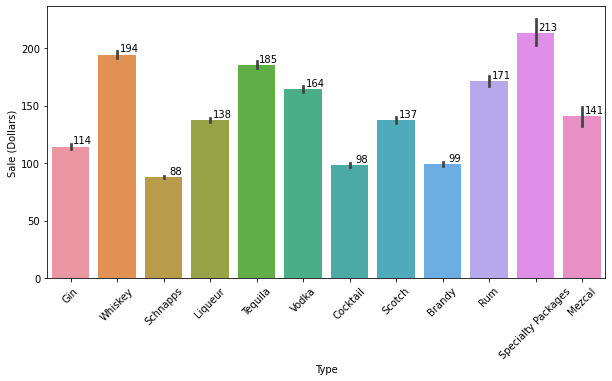

In [25]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Type", y = "Sale (Dollars)", data = foodstore)
plt.xticks(rotation=45)

    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(12, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

### Wine and spirit sales by liquor type

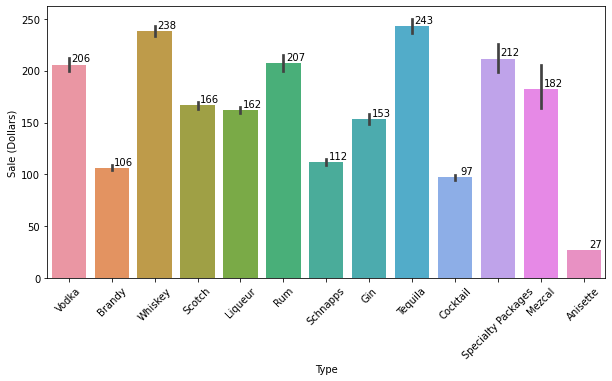

In [26]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Type", y = "Sale (Dollars)", data = wine_spirit)
plt.xticks(rotation=45)

    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(12, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

### Drugstore sales by liquor type

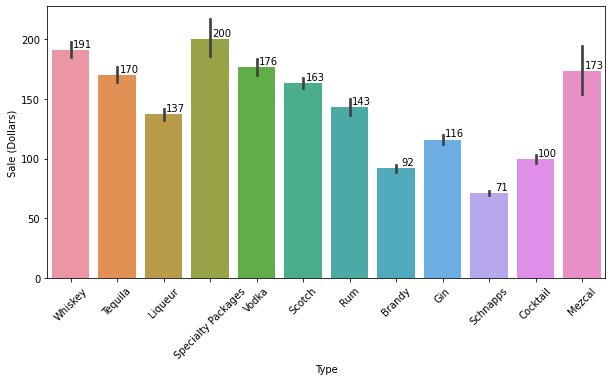

In [27]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Type", y = "Sale (Dollars)", data = drugstore)
plt.xticks(rotation=45)

    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(12, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

## Sale By Time

### Month

In [150]:
month_sales_2021 = hv[hv["Year"] == 2021]
month_store_sales_2021 = pd.DataFrame(month_sales_2021.groupby(["Month"])["Sale (Dollars)"].sum().sort_values(ascending=False)).reset_index()
month_store_sales_2021

,Month,Sale (Dollars)
0,10,14013525.37
1,12,12614588.25
2,11,11217416.78
3,6,11182467.32
4,9,10901364.33
5,3,10718547.28
6,8,10550162.21
7,4,10282703.45
8,7,9930540.75
9,5,9846287.04


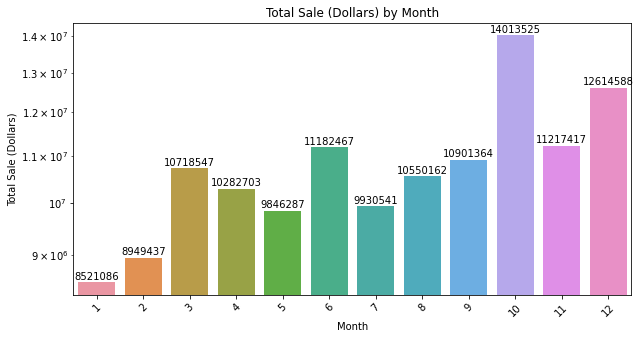

In [151]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Month", y = "Sale (Dollars)", data = month_store_sales_2021)
plt.xticks(rotation=45)
plt.yscale("log")
plt.ylabel('Total Sale (Dollars)')
plt.title('Total Sale (Dollars) by Month')
    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

In [28]:
month_sales = pd.DataFrame(hv.groupby(["Month"])["Sale (Dollars)"].sum().sort_values(ascending=False)).reset_index()
month_sales

,Month,Sale (Dollars)
0,3,30483526.01
1,7,29753063.44
2,12,28782982.93
3,2,27253304.83
4,1,24083549.54
5,6,22093623.90
6,4,20772737.78
7,11,20747336.11
8,8,20483894.91
9,5,19549554.67


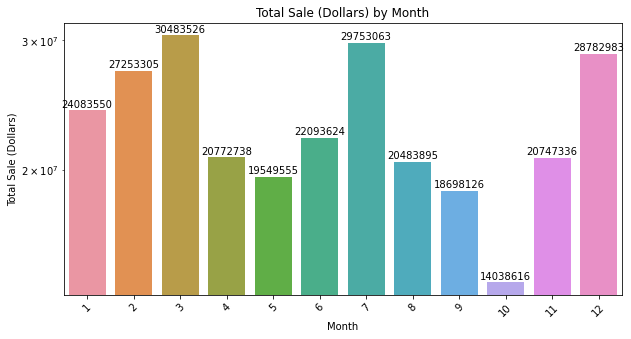

In [29]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Month", y = "Sale (Dollars)", data = month_sales)
plt.xticks(rotation=45)
plt.yscale("log")
plt.ylabel('Total Sale (Dollars)')
plt.title('Total Sale (Dollars) by Month')
    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

In [30]:
hv[hv["Month"] == 9]["Sale (Dollars)"].sum()

18698126.470000003

### Sale By Year

In [31]:
yearly_sales = pd.DataFrame(hv.groupby(["Year"])["Sale (Dollars)"].sum().sort_values(ascending=False)).reset_index()
yearly_sales

,Year,Sale (Dollars)
0,2021,1.287281e+08
1,2020,1.069798e+08
2,2022,2.836024e+07
3,2019,1.263035e+07
4,2016,3.106487e+04
5,2018,1.023461e+04
6,2017,5.262300e+02


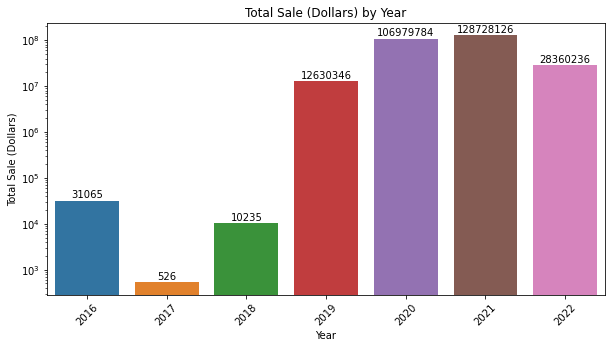

In [32]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Year", y = "Sale (Dollars)", data = yearly_sales)
plt.xticks(rotation=45)
plt.yscale("log")
plt.ylabel('Total Sale (Dollars)')
plt.title('Total Sale (Dollars) by Year')
    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

## Sale by store category

In [118]:
storecat_2021 = hv[hv["Year"] == 2021]
store_sales_2021 = pd.DataFrame(storecat_2021.groupby(["Store Category"])["Sale (Dollars)"].sum().sort_values(ascending=False)).reset_index()
store_sales_2021

,Store Category,Sale (Dollars)
0,Food Store,52690326.59
1,Supermarket,38830019.07
2,Wine & Spirits,24932900.19
3,Drugstore,7385959.78
4,Food & Drugstore,4091343.55
5,Fast & Fresh,652413.24
6,Gas,145163.19


### Unique store numbers per store category

In [159]:
len(storecat_2021[storecat_2021["Store Category"] == "Food Store"]["Store Number"].unique())

58

In [160]:
len(storecat_2021[storecat_2021["Store Category"] == "Supermarket"]["Store Number"].unique())

45

In [161]:
len(storecat_2021[storecat_2021["Store Category"] == "Wine & Spirits"]["Store Number"].unique())

21

In [162]:
len(storecat_2021[storecat_2021["Store Category"] == "Drugstore"]["Store Number"].unique())

9

In [163]:
len(storecat_2021[storecat_2021["Store Category"] == "Food & Drugstore"]["Store Number"].unique())

3

In [164]:
len(storecat_2021[storecat_2021["Store Category"] == "Fast & Fresh"]["Store Number"].unique())

16

In [165]:
len(storecat_2021[storecat_2021["Store Category"] == "Gas"]["Store Number"].unique())

9

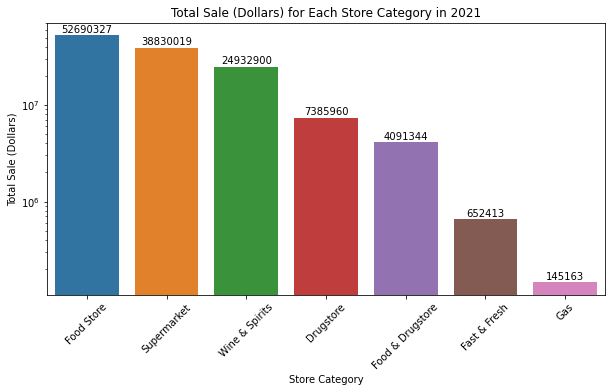

In [122]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Store Category", y = "Sale (Dollars)", data = store_sales_2021)
plt.xticks(rotation=45)
plt.yscale("log")
plt.ylabel('Total Sale (Dollars)')
plt.title('Total Sale (Dollars) for Each Store Category in 2021')
    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

In [34]:
store_sales = pd.DataFrame(hv.groupby(["Store Category"])["Sale (Dollars)"].sum().sort_values(ascending=False)).reset_index()
store_sales

,Store Category,Sale (Dollars)
0,Food Store,1.152827e+08
1,Supermarket,8.031154e+07
2,Wine & Spirits,5.391428e+07
3,Drugstore,1.661517e+07
4,Food & Drugstore,9.061924e+06
5,Fast & Fresh,1.275901e+06
6,Gas,2.787540e+05


In [35]:
store_sales = pd.DataFrame(hv.groupby(["Store Category"])["Sale (Dollars)"].sum().sort_values(ascending=False)).reset_index()
store_sales

,Store Category,Sale (Dollars)
0,Food Store,1.152827e+08
1,Supermarket,8.031154e+07
2,Wine & Spirits,5.391428e+07
3,Drugstore,1.661517e+07
4,Food & Drugstore,9.061924e+06
5,Fast & Fresh,1.275901e+06
6,Gas,2.787540e+05


In [36]:
store_sales = pd.DataFrame(hv.groupby(["Store Category"])["Sale (Dollars)"].sum().sort_values(ascending=False)).reset_index()
store_sales

,Store Category,Sale (Dollars)
0,Food Store,1.152827e+08
1,Supermarket,8.031154e+07
2,Wine & Spirits,5.391428e+07
3,Drugstore,1.661517e+07
4,Food & Drugstore,9.061924e+06
5,Fast & Fresh,1.275901e+06
6,Gas,2.787540e+05


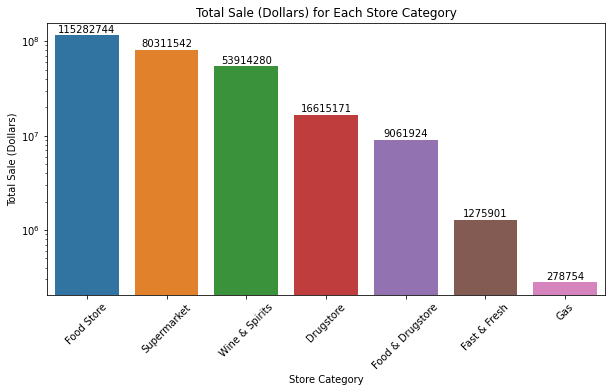

In [37]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Store Category", y = "Sale (Dollars)", data = store_sales)
plt.xticks(rotation=45)
plt.yscale("log")
plt.ylabel('Total Sale (Dollars)')
plt.title('Total Sale (Dollars) for Each Store Category')
    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

In [38]:
len(hv[hv["Year"] == 2016]["Store Number"].unique())

17

In [39]:
#hv[hv["Year"] == 2017]["Store Category"].value_counts()
len(hv[hv["Year"] == 2017]["Store Number"].unique())

1

In [40]:
#hv[hv["Year"] == 2018]["Store Category"].value_counts()
len(hv[hv["Year"] == 2018]["Store Number"].unique())

8

In [41]:
len(hv[hv["Year"] == 2019]["Store Number"].unique())

126

In [42]:
len(hv[hv["Year"] == 2020]["Store Number"].unique())

156

In [43]:
len(hv[hv["Year"] == 2021]["Store Number"].unique())

161

In [44]:
len(hv[hv["Year"] == 2022]["Store Number"].unique())

158

In [115]:
hv["Store Category"].unique().value_counts()

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [46]:
len(hv[hv["Store Category"] == "Food Store"]["Store Number"].unique())

58

In [47]:
len(hv[hv["Store Category"] == "Supermarket"]["Store Number"].unique())

48

In [48]:
len(hv[hv["Store Category"] == "Wine & Spirits"]["Store Number"].unique())

21

In [49]:
115292744 / 728414 

158.2791434541346

## Sale by county

In [152]:
county_sales_2021 = hv[hv["Year"] == 2021]
county_sales_2021 = pd.DataFrame(county_sales_2021.groupby(["County"])["Sale (Dollars)"].sum().sort_values(ascending=False)).reset_index()[:10]
county_sales_2021

,County,Sale (Dollars)
0,POLK,39220601.56
1,JOHNSON,11545104.85
2,LINN,10198822.13
3,SCOTT,7925419.47
4,BLACK HAWK,4012917.67
5,WOODBURY,3737704.94
6,STORY,3725982.39
7,POTTAWATTA,3201781.80
8,CERRO GORD,3103792.68
9,DALLAS,3085746.44


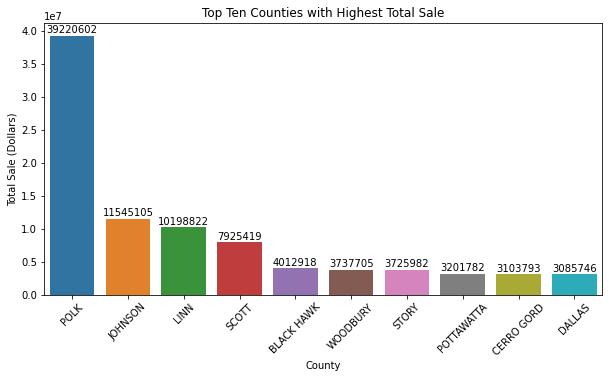

In [153]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "County", y = "Sale (Dollars)", data = county_sales_2021)
plt.xticks(rotation=45)
plt.ylabel('Total Sale (Dollars)')
plt.title('Top Ten Counties with Highest Total Sale')
    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

In [50]:
county_sales = pd.DataFrame(hv.groupby(["County"])["Sale (Dollars)"].sum().sort_values(ascending=False)).reset_index()[:10]
county_sales

,County,Sale (Dollars)
0,POLK,80674141.13
1,JOHNSON,23711867.16
2,LINN,22864341.82
3,SCOTT,17483864.16
4,BLACK HAWK,8917544.38
5,STORY,8185190.52
6,WOODBURY,8176029.77
7,POTTAWATTA,7382037.11
8,CERRO GORD,6920080.30
9,DALLAS,6640423.78


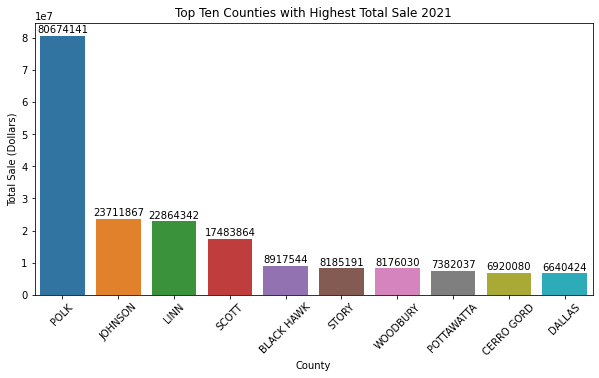

In [154]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "County", y = "Sale (Dollars)", data = county_sales)
plt.xticks(rotation=45)
plt.ylabel('Total Sale (Dollars)')
plt.title('Top Ten Counties with Highest Total Sale 2021')
    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

In [155]:
county_bottles_sold_2021 = hv[hv["Year"] == 2021]
county_bottles_2021 = pd.DataFrame(county_bottles_sold_2021.groupby(["County"])["Bottles Sold"].sum().sort_values(ascending=False)).reset_index()[:10]
county_bottles_2021

,County,Bottles Sold
0,POLK,2494132
1,LINN,746985
2,JOHNSON,722412
3,SCOTT,508097
4,BLACK HAWK,263443
5,WOODBURY,243707
6,STORY,231753
7,CERRO GORD,224698
8,POTTAWATTA,202338
9,DALLAS,194734


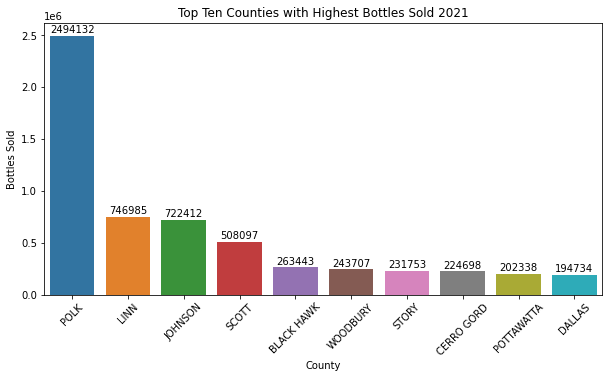

In [157]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "County", y = "Bottles Sold", data = county_bottles_2021)
plt.xticks(rotation=45)
plt.ylabel('Bottles Sold')
plt.title('Top Ten Counties with Highest Bottles Sold 2021')
    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

In [52]:
county_bottles_sold = pd.DataFrame(hv.groupby(["County"])["Bottles Sold"].sum().sort_values(ascending=False)).reset_index()[:10]
county_bottles_sold

,County,Bottles Sold
0,POLK,5266541
1,LINN,1713475
2,JOHNSON,1468671
3,SCOTT,1144220
4,BLACK HAWK,593959
5,WOODBURY,540838
6,STORY,518070
7,CERRO GORD,495054
8,POTTAWATTA,479111
9,DALLAS,427962


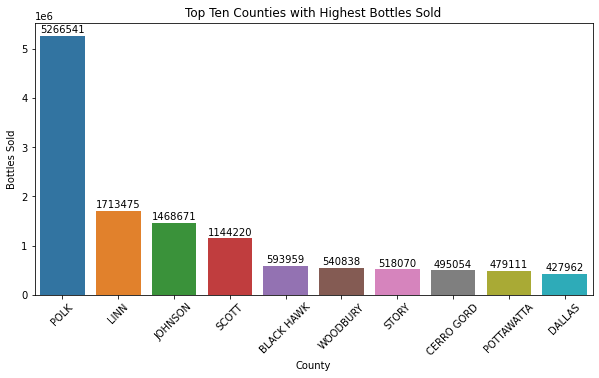

In [53]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "County", y = "Bottles Sold", data = county_bottles_sold)
plt.xticks(rotation=45)
plt.ylabel('Bottles Sold')
plt.title('Top Ten Counties with Highest Bottles Sold')
    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

Order of the total sale and bottles sold is different
- look into what is the top product sold then compare price for each item

In [54]:
hv.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Store Category,Year,Month,Type
0,INV-24107200133,2019-12-23,2508,Hy-Vee Food Store #1 / Cedar Rapids,"1843 Johnson Avenue, N.W.",Cedar Rapids,52405,POINT (-91.697941 41.97447),57,LINN,1041100,American Dry Gins,370,PERNOD RICARD USA,32236,Seagrams Extra Dry Gin,12,750.0,6.49,9.74,12,116.88,9.00,2.37,Food Store,2019,12,Gin
1,INV-24090200052,2019-12-20,2649,Hy-Vee #3 / Dubuque,400 Locust St,Dubuque,52001,POINT (-90.666497 42.49721900000001),31,DUBUQUE,1011400,Tennessee Whiskies,85,Brown Forman Corp.,26826,Jack Daniels Old #7 Black Label,12,750.0,15.57,23.36,12,280.32,9.00,2.37,Supermarket,2019,12,Whiskey
2,INV-24117700068,2019-12-23,2567,Hy-Vee Drugstore / Davenport,2200 West Kimberly,Davenport,52806,POINT (-90.608201 41.560663),82,SCOTT,1011200,Straight Bourbon Whiskies,65,Jim Beam Brands,19066,Jim Beam,12,750.0,10.50,15.75,6,94.50,4.50,1.18,Drugstore,2019,12,Whiskey
3,INV-24105000057,2019-12-23,2538,Hy-Vee Food Store #3 / Waterloo,1422 Flammang Dr,Waterloo,50702,POINT (-92.327917 42.459938),7,BLACK HAWK,1011100,Blended Whiskies,65,Jim Beam Brands,24456,Kessler Blend Whiskey,12,750.0,5.51,8.27,3,24.81,2.25,0.59,Food Store,2019,12,Whiskey
4,INV-24117300020,2019-12-23,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1011100,Blended Whiskies,65,Jim Beam Brands,27680,Jim Beam Kentucky Fire Mini,12,50.0,5.40,8.10,12,97.20,0.60,0.15,Drugstore,2019,12,Whiskey


In [55]:
hv[hv["County"]=="LINN"]["Item Description"].value_counts()[:5]

Titos Handmade Vodka         2184
Fireball Cinnamon Whiskey    2075
Black Velvet                 1990
Hawkeye Vodka                1913
Crown Royal                  1279
Name: Item Description, dtype: int64

In [56]:
hv[hv["County"]=="JOHNSON"]["Item Description"].value_counts()[:5]

Titos Handmade Vodka         1033
Black Velvet                  949
Fireball Cinnamon Whiskey     902
Hawkeye Vodka                 852
Crown Royal                   825
Name: Item Description, dtype: int64

### Price, Profit and transaction for Titos

#### unique stores per county

In [57]:
len(hv[hv["County"]=="JOHNSON"]["Store Number"].unique())

7

In [58]:
len(hv[hv["County"]=="LINN"]["Store Number"].unique())

13

#### med sale price per transaction

In [59]:
hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Titos Handmade Vodka")]["Sale (Dollars)"].median()

855.0

In [123]:
hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Titos Handmade Vodka")]["Sale (Dollars)"].median()

228.12

#### median retail price

In [124]:
hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Retail"].median()

19.01

In [125]:
hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Retail"].median()

15.0

#### median Bottle Cost

In [127]:
hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Cost"].median()

12.67

In [126]:
hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Cost"].median()

10.0

#### median Profit

In [128]:
hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Retail"].median() - hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Cost"].median()

6.340000000000002

In [129]:
hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Retail"].median() - hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Cost"].median()

5.0

#### Markup Percentage

In [130]:
((hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Retail"].median() - hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Cost"].median()) / (hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Cost"].median())) * 100

50.039463299131825

In [131]:
((hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Retail"].median() - hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Cost"].median()) / (hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Cost"].median())) * 100

50.0

### Price for Fireball

#### Transactions per county

In [69]:
len((hv["County"]=="JOHNSON") & (hv["Item Description"] == "Fireball Cinnamon Whiskey"))

1570810

In [70]:
len((hv["County"]=="LINN") & (hv["Item Description"] == "Fireball Cinnamon Whiskey"))

1570810

In [71]:
len((hv["County"]=="JOHNSON") & (hv["Item Description"] == "Fireball Cinnamon Whiskey"))

1570810

#### median Sale Price

In [132]:
hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["Sale (Dollars)"].median()

162.0

In [133]:
hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["Sale (Dollars)"].median()

162.0

#### median retail price

In [134]:
hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Retail"].median()

13.5

In [135]:
hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Retail"].median()

3.75

#### median Bottle Cost

In [136]:
hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Cost"].median()

9.0

In [137]:
hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Cost"].median()

2.5

#### median Profit

In [138]:
hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Retail"].median() - hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Cost"].median()

4.5

In [139]:
hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Retail"].median() - hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Cost"].median()

1.25

#### Markup Percentage

In [140]:
((hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Retail"].median() - hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Cost"].median()) / (hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Cost"].median())) * 100

50.0

In [141]:
((hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Retail"].median() - hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Cost"].median()) / (hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Cost"].median())) * 100

50.0

TypeError: 'AxesSubplot' object is not subscriptable

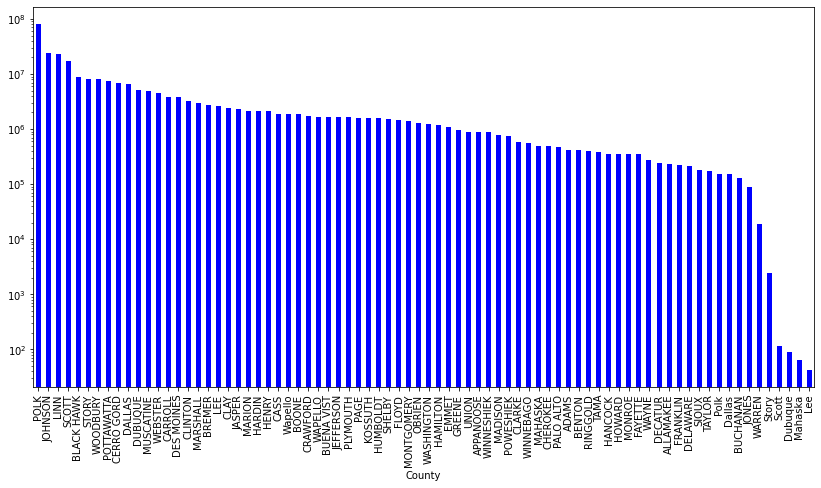

In [82]:
plt.figure(figsize = (14,7))
plt.yscale("log")
hv.groupby("County")["Sale (Dollars)"].sum().sort_values(ascending=False).plot.bar(color = 'b')[:10]

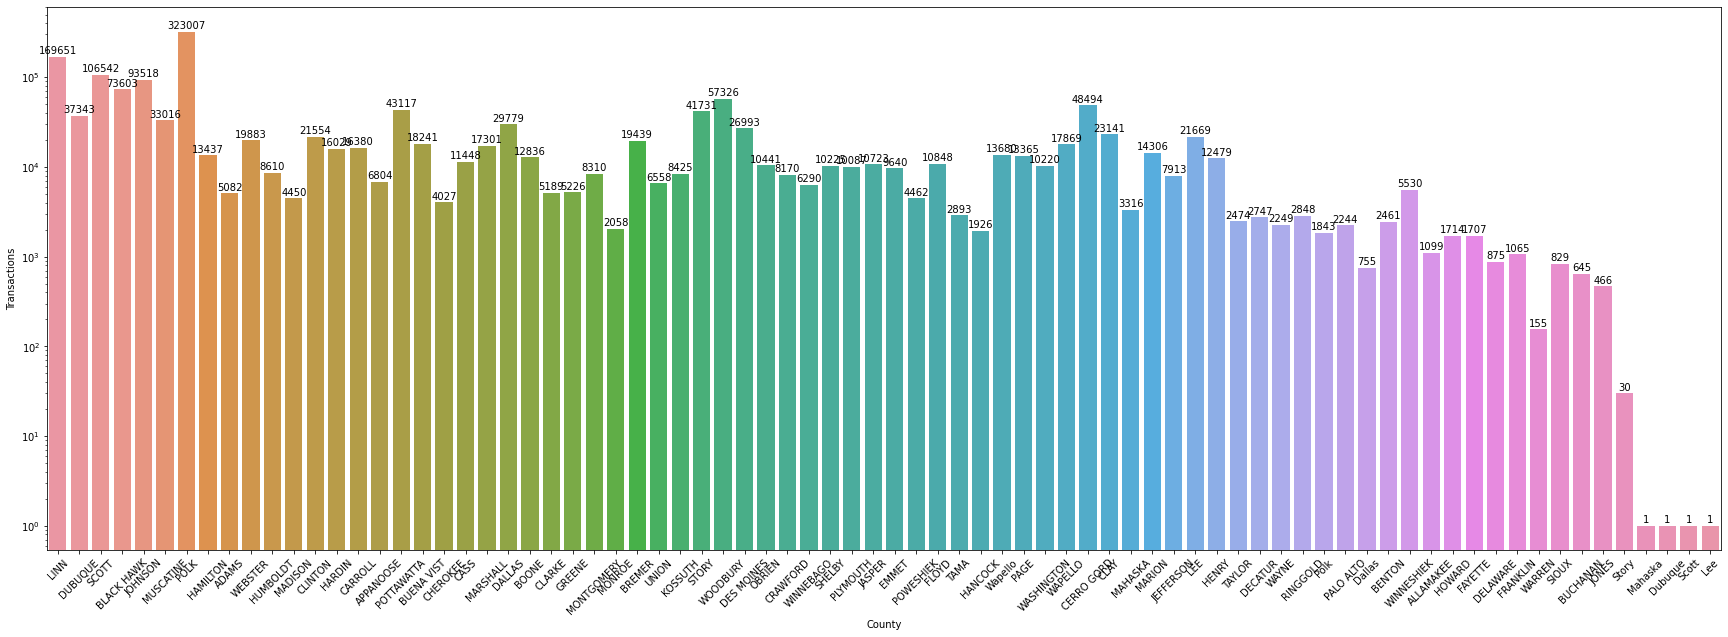

In [83]:
plt.figure(figsize=(30, 10))
ax = sns.countplot(hv['County'])
plt.xticks(rotation=45)
plt.yscale("log")
plt.xlabel('County')
plt.ylabel('Transactions')

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

### liquor sales by type in 2021

In [142]:
liquor_type_sales_2021 = hv[hv["Year"] == 2021]
liquor_type_sales = pd.DataFrame(liquor_type_sales_2021.groupby(["Type"])["Sale (Dollars)"].sum().sort_values(ascending=False)).reset_index()
liquor_type_sales

,Type,Sale (Dollars)
0,Whiskey,39349008.57
1,Vodka,29502699.73
2,Liqueur,16761125.12
3,Rum,12753162.49
4,Tequila,9909271.06
5,Schnapps,4045889.83
6,Scotch,3670287.66
7,Gin,3644013.66
8,Cocktail,3217584.06
9,Specialty Packages,2926272.18


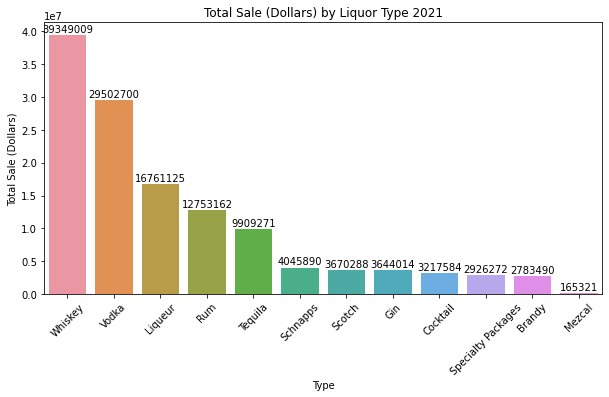

In [144]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Type", y = "Sale (Dollars)", data = liquor_type_sales)
plt.xticks(rotation=45)
plt.ylabel('Total Sale (Dollars)')
plt.title('Total Sale (Dollars) by Liquor Type 2021')
    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

### liquor bottles sold by type 2021

In [145]:
liquor_type_bottles_2021 = pd.DataFrame(liquor_type_sales_2021.groupby(["Type"])["Bottles Sold"].sum().sort_values(ascending=False)).reset_index()
liquor_type_bottles_2021

,Type,Bottles Sold
0,Vodka,2261367
1,Whiskey,1969688
2,Liqueur,1533583
3,Rum,842262
4,Tequila,459834
5,Schnapps,358506
6,Cocktail,313792
7,Gin,217447
8,Brandy,187926
9,Specialty Packages,134335


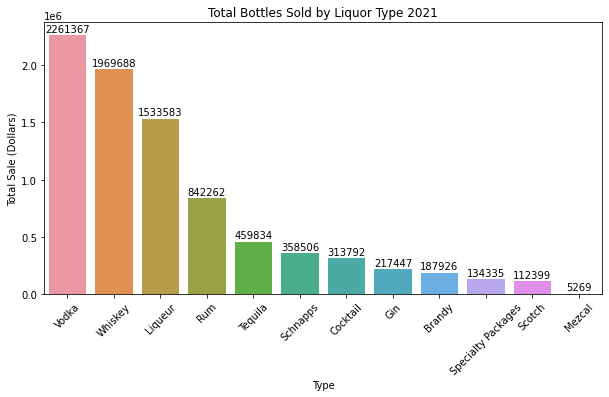

In [147]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Type", y = "Bottles Sold", data = liquor_type_bottles_2021)
plt.xticks(rotation=45)
plt.ylabel('Total Sale (Dollars)')
plt.title('Total Bottles Sold by Liquor Type 2021')
    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

### timeseries

In [97]:
sales_by_year =  pd.DataFrame(hv.groupby("Year")["Sale (Dollars)"].sum()).reset_index()
sales_by_year.head()

,Year,Sale (Dollars)
0,2016,3.106487e+04
1,2017,5.262300e+02
2,2018,1.023461e+04
3,2019,1.263035e+07
4,2020,1.069798e+08


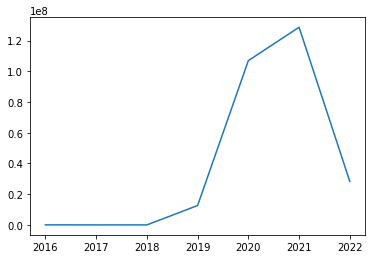

In [98]:
plt.plot(sales_by_year["Year"],sales_by_year["Sale (Dollars)"])

In [99]:
store_sales_by_year =  pd.DataFrame(hv.groupby(["Store Category"])["Sale (Dollars)"].sum()).reset_index()
store_sales_by_year.head()

,Store Category,Sale (Dollars)
0,Drugstore,1.661517e+07
1,Fast & Fresh,1.275901e+06
2,Food & Drugstore,9.061924e+06
3,Food Store,1.152827e+08
4,Gas,2.787540e+05


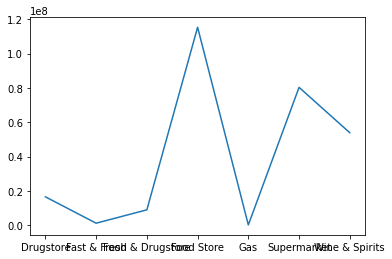

In [100]:
plt.plot(store_sales_by_year["Store Category"],store_sales_by_year["Sale (Dollars)"])

In [101]:
hv.head(3)

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Store Category,Year,Month,Type,Latitude,Longitude
0,INV-24107200133,2019-12-23,2508,Hy-Vee Food Store #1 / Cedar Rapids,"1843 Johnson Avenue, N.W.",Cedar Rapids,52405,POINT (-91.697941 41.97447),57,LINN,1041100,American Dry Gins,370,PERNOD RICARD USA,32236,Seagrams Extra Dry Gin,12,750.0,6.49,9.74,12,116.88,9.0,2.37,Food Store,2019,12,Gin,-91.697941,41.974470
1,INV-24090200052,2019-12-20,2649,Hy-Vee #3 / Dubuque,400 Locust St,Dubuque,52001,POINT (-90.666497 42.49721900000001),31,DUBUQUE,1011400,Tennessee Whiskies,85,Brown Forman Corp.,26826,Jack Daniels Old #7 Black Label,12,750.0,15.57,23.36,12,280.32,9.0,2.37,Supermarket,2019,12,Whiskey,-90.666497,42.497219
2,INV-24117700068,2019-12-23,2567,Hy-Vee Drugstore / Davenport,2200 West Kimberly,Davenport,52806,POINT (-90.608201 41.560663),82,SCOTT,1011200,Straight Bourbon Whiskies,65,Jim Beam Brands,19066,Jim Beam,12,750.0,10.50,15.75,6,94.50,4.5,1.18,Drugstore,2019,12,Whiskey,-90.608201,41.560663


In [102]:
sm_sale_year = hv[hv["Store Category"] == "Supermarket"][["Year","Sale (Dollars)"]]
sm_sale_year.head()

,Year,Sale (Dollars)
1,2019,280.32
16,2019,169.56
19,2019,189.00
21,2019,94.56
28,2019,25.20


In [103]:
sm_sale_year.rename(columns = {'Sale (Dollars)':'Sale'}, inplace = True)
sm_sale_year.head()

,Year,Sale
1,2019,280.32
16,2019,169.56
19,2019,189.00
21,2019,94.56
28,2019,25.20


In [104]:
# import datetime
# hv["Month_Year"] = pd.to_datetime(hv[["Month", "Year"]])

In [105]:
store_sales_by_year =  pd.DataFrame(hv.groupby(["Store Category"])["Sale (Dollars)"].sum()).reset_index()
store_sales_by_year.head()

,Store Category,Sale (Dollars)
0,Drugstore,1.661517e+07
1,Fast & Fresh,1.275901e+06
2,Food & Drugstore,9.061924e+06
3,Food Store,1.152827e+08
4,Gas,2.787540e+05


- MBA
    - group by store and day
    - each store number is person
    - each day is a transaction
    - so 7 transactions max in a week per store number

# MBA

In our current data, a single row consists of the order of a single liquor product item. In order for the technique to be applicable, we aggregate the data according to the customers (in this case the store number), dates with a weekly or a monthly frequency.

In [108]:
mba_df2 = hv.groupby(["Store Number","Date"])["Item Description"].apply(list).reset_index()
mba_df2 = pd.DataFrame(mba_df2)
mba_df2.head(10)

,Store Number,Date,Item Description
0,2500,2016-03-23,[Hawkeye Vodka]
1,2500,2016-03-30,"[Popov Vodka 80 Prf, Old Crow, Captain Morgan ..."
2,2500,2016-04-13,"[Old Crow, Paramount Triple Sec, Bushmills Iri..."
3,2500,2016-04-20,"[Burnett's Gin London Dry, Bacardi 151 Prf, Ba..."
4,2500,2016-04-27,[Southern Comfort]
5,2500,2016-05-04,"[Juarez Tequila Gold, Lady Bligh]"
6,2500,2016-05-11,[Smirnoff Orange]
7,2500,2016-05-18,[Kraken Black Spiced Rum]
8,2500,2016-05-25,[Godiva Liqueur]
9,2500,2016-06-15,[Hawkeye Gin]


In [109]:
mba_df2_csv = mba_df2.to_csv('mba_df2.csv', index = True)

In [110]:
mba_df2.shape

(18110, 3)

In [111]:
transactions = []
for i in range(0, 18110):
  transactions.extend(mba_df2["Item Description"])

In [112]:
transactions[:2]

[['Hawkeye Vodka'],
 ['Popov Vodka 80 Prf',
  'Old Crow',
  'Captain Morgan Spiced Rum',
  'Five Star Pet',
  'Three Olives Vodka',
  'Johnnie Walker Black']]

In [113]:
from apyori import apriori
rules = apriori(transactions =transactions, min_support = 0.003, min_confidence = 0.2, min_lift = 3, min_length = 2, max_length = 2)

In [114]:
results = list(rules)

KeyboardInterrupt: 

In [ ]:
results[:-1]

In [ ]:
def inspect(results):
    lhs         = [tuple(result[2][0][0])[0] for result in results]
    rhs         = [tuple(result[2][0][1])[0] for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    return list(zip(lhs, rhs, supports, confidences, lifts))
resultsinDataFrame = pd.DataFrame(inspect(results), columns = ['Left Hand Side', 'Right Hand Side', 'Support', 'Confidence', 'Lift'])

In [ ]:
resultsinDataFrame

In [ ]:
mba_df = hv.groupby(["Store Number","Date","Month","Year"]).apply(lambda d: d["Item Description"].tolist())
mba_df = pd.DataFrame(mba_df.tolist(), index=mba_df.index)
mba_df.head(10)

In [ ]:
mba_df.reset_index(inplace = True)
mba_df.head()

In [ ]:
mba_df_csv = mba_df.to_csv('mba_df.csv', index = True)

In [ ]:
mba_df2 = hv.groupby(["Store Number","Date","Month","Year", "County Number", "Store Category"]).apply(lambda d: d["Item Description"].tolist())
mba_df2 = pd.DataFrame(mba_df2.tolist(), index=mba_df2.index)
mba_df2.head(10)

In [ ]:
mba_df2.reset_index(inplace = True)
mba_df2.head()

In [ ]:
mba_df_2_csv = mba_df2.to_csv('mba_df2.csv', index = True)

In [ ]:
# mba_df.shape

In [ ]:
# num_rows = 18110
# num_cols = 834
# transactions = mba_df.iloc[:num_rows, 4:num_cols].astype(str).values.tolist()

In [ ]:
# transactions[:2]

In [ ]:
# results = list(rules)

In [ ]:
# results[:2]

In [ ]:
mba_df["Store Number"] = mba_df["Store Number"].astype(int)
mba_df["Date"] =  pd.to_datetime(hv["Date"], format="%m/%d/%Y")
mba_df["Month"] = mba_df["Month"].astype(int)
mba_df["Year"] = mba_df["Year"].astype(int)